In [1]:
import os
import numpy as np
import cv2
import glob
import time
from cPickle import load, dump, HIGHEST_PROTOCOL
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

from skimage.feature import hog
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    if len(img.shape)>2:
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    elif len(img.shape)==2:
        hist_features = np.histogram(img, bins=nbins, range=bins_range)
        
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [3]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        
        # Read in each one by one
        #image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
            elif color_space == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL' and len(feature_image.shape)>2:
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            elif hog_channel == 'ALL' and len(feature_image.shape)==2:
                hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)                
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
    else: 
        feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL' and len(feature_image.shape)>2:
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        elif hog_channel == 'ALL' and len(feature_image.shape)==2:
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)            
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [4]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window = ((startx, starty), (endx, endy))
            window_list.append(window)
            # windows of size 96x96
            #print  (window[1][0]-window[0][0], window[1][1]-window[0][1])
    # Return the list of windows
    return window_list

# Define a function you will pass an image and
# the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, probabilityMap=[]):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        # discard very small windows
        y1 = window[0][1]
        y2 = window[1][1]
        x1 = window[0][0]
        x2 = window[1][0]
#         if abs(y1-y2)<50 and abs(x1-x2)<50:
#             continue
            
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        # prediction = clf.predict(test_features)
        prediction = clf.predict_proba(test_features)
        conf = np.max(prediction)
        label = np.argmax(prediction)
        
        if len(probabilityMap)>0:
            win = [[x[0],x[1]] for x in window]
            H,W = probabilityMap.shape
            win[0][0] = max(win[0][0], 0)
            win[0][1] = max(win[0][1], 0)
            win[1][0] = min(win[1][0], W-1)            
            win[1][1] = min(win[1][1], H-1)
            probabilityMapWindow = np.mean(probabilityMap[win[0][1]:win[1][1], win[0][0]:win[1][0]])
            # print 'probabilityMapWindow = ',probabilityMapWindow
        else:
            probabilityMapWindow = 0.0
            
            
#         probabilityMapWindow = 0.0
        #7) If positive (prediction == 1) then save the window
        conf += probabilityMapWindow
        if conf>0.5 and label==1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [5]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [6]:
# Read in cars and notcars
cars = glob.glob('datasets/vehicles/*/*.png') + glob.glob('datasets/autti-vehicles/*.png')
notcars = glob.glob('datasets/non-vehicles/*/*.png') + glob.glob('datasets/manual-non-vehicles/*.png')

# Check that arrays are not empty
print len(cars)
print len(notcars)

0
0


In [7]:
# Reduce the sample size because, for quickly testing the pipeline
# sample_size = 100
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

In [8]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'GRAY' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_windows()


In [9]:
dist = {}
if not os.path.exists('dist.pkl'):
    car_data = [mpimg.imread(fname) for fname in cars]
    noncar_data = [mpimg.imread(fname) for fname in notcars]
        
    car_features = extract_features(car_data, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(noncar_data, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    print 'X max = ',np.max(X)
    print 'X min = ',np.min(X)
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    dist['X_scaler'] = X_scaler

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into RANDOMIZED training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    # svc = LinearSVC()
    # svc = SVC(kernel='linear', C=1.0, probability=True)
    svc = SVC(kernel='rbf', C=10.0, probability=True)

    # svr = svm.SVC() 
    # parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]} 
    # clf = grid_search.GridSearchCV(svr, parameters) 
    # print 'clf.best_params_ = ',clf.best_params_

    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    dist['svc'] = svc
    dump(dist, open('dist.pkl', 'wb'), HIGHEST_PROTOCOL)
else:
    dist = load(open('dist.pkl', 'rb'))
    svc = dist['svc']
    X_scaler = dist['X_scaler']
    
# prob = svc.predict_proba(X_test[0])
# print np.max(prob), np.argmax(prob)


In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def plot2(im1, im2, name1, name2, cmap1=None, cmap2=None, write=None):
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))                
    if cmap1:
        ax1.imshow(im1, cmap=cmap1)
    else:
        ax1.imshow(im1)
    ax1.set_title(name1, fontsize=20)
    if cmap2:
        ax2.imshow(im2, cmap=cmap2)
    else:
        ax2.imshow(im2)
    ax2.set_title(name2, fontsize=20)

min heat =  0.0
max heat =  2.0


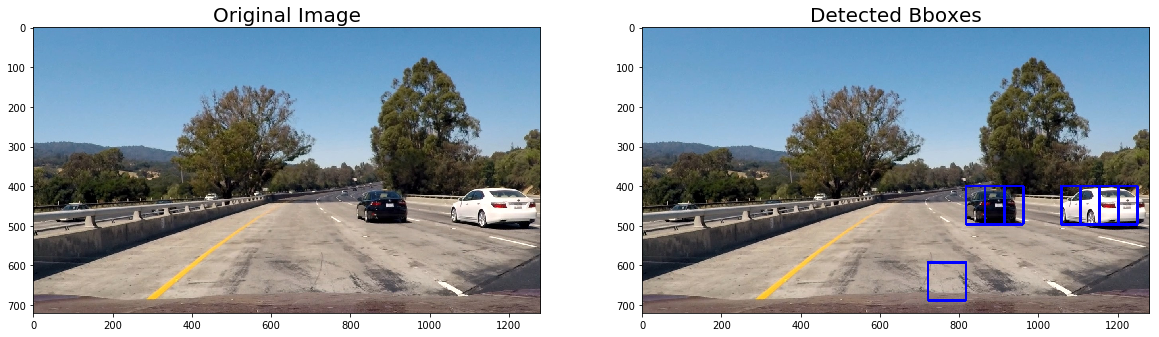

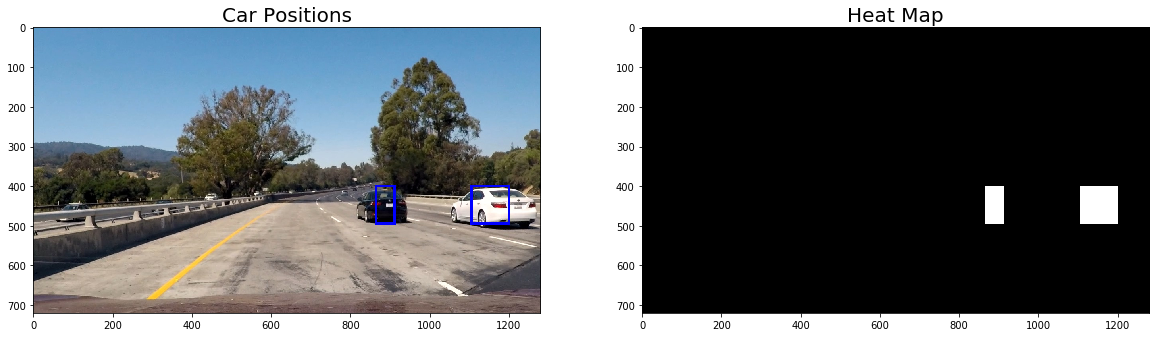

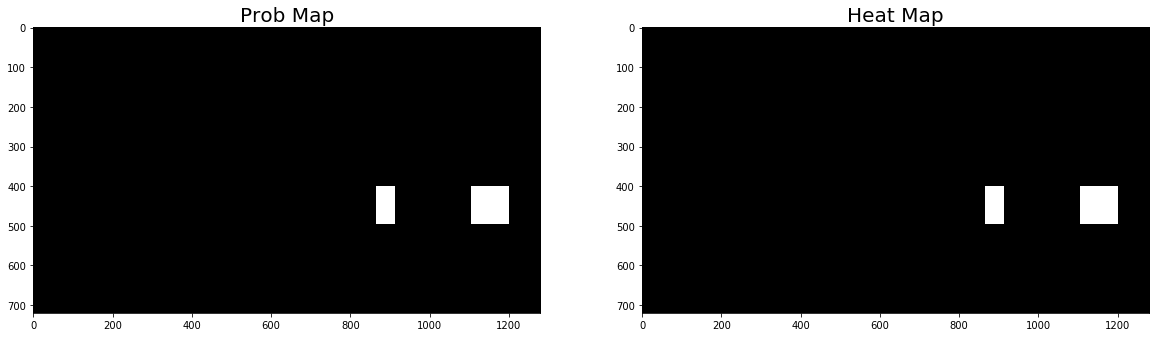

In [11]:
# Check the prediction time for a single sample
t = time.time()
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_windows(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, probabilityMap=[])                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
print 'min heat = ',np.min(heat)
print 'max heat = ',np.max(heat)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

plot2(image, window_img, 'Original Image', 'Detected Bboxes')
plot2(draw_img, heatmap, 'Car Positions', 'Heat Map', None, 'gray')

# give 0.1 score to all detected pixels for THIS frame
probabilityMapCurrent = np.copy(heatmap)
probabilityMapCurrent[np.where(heatmap>0)] = 0.1

plot2(probabilityMapCurrent, heatmap, 'Prob Map', 'Heat Map', 'gray', 'gray')

In [ ]:

def load_test_video(file_name='project_video.mp4'):
    images = []
    d = {'count' : 0}
    
    def convert_frame(img):
        f="%s - %d" % (file_name, d['count'])
        d['count'] += 1
        return (f,img)
    
    clip = VideoFileClip(file_name)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]    
    return images


# load images from projet video provided
images = []
images = load_test_video()

100%|█████████▉| 1260/1261 [00:07<00:00, 161.18it/s]


In [ ]:
out_dir = 'output_images'

# Lets use some temporal info
image = images[0][1]
PROBABILITY_MAP = np.zeros_like(image[:,:,0]).astype(np.float)
LAST_K_FRAMES = 3
PROBABILITY_MAPS_LAST_K = []
probabilityMapCurrentUpdated = np.zeros_like(image[:,:,0]).astype(np.float)

for idx,image in enumerate(images):
    image = image[1]
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # image = image.astype(np.float32)/255

    windows = slide_windows(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    
    hot_windows = search_windows(image, windows, svc, 
                            X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, 
                            probabilityMap=probabilityMapCurrentUpdated)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.imshow(window_img)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # give +ve score to all detected pixels for THIS frame
    probabilityMapCurrent = np.zeros_like(image[:,:,0]).astype(np.float)
    probabilityMapCurrent[np.where(heatmap>1)] = 0.1
    probabilityMapCurrent[np.where(heatmap==0)] = -0.1
    
    # store last-K probability maps
    if len(PROBABILITY_MAPS_LAST_K)<=LAST_K_FRAMES:
        PROBABILITY_MAPS_LAST_K.append(probabilityMapCurrent)
        if len(PROBABILITY_MAPS_LAST_K)>LAST_K_FRAMES:
            PROBABILITY_MAPS_LAST_K.pop(0)
    
    pmap = np.array(PROBABILITY_MAPS_LAST_K)
    probabilityMapCurrentUpdated = np.ndarray.sum(pmap, axis=0)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fOut = os.path.join(out_dir, str(idx) + '.jpg')
    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
#     cv2.imwrite(fOut, draw_img) 
